<a href="https://colab.research.google.com/github/ven-diagram/COMP61332_Coursework/blob/main/polynomial_solver_sigmoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from mpmath import mp

# Change target floating precision here
dtype = np.float16

In [8]:
def GetRndInterval(n):

  # Finds the previous value in target precision
  def get_prec_val(y):
    y_fp = dtype(y)
    prev = np.nextafter(y_fp, -np.inf, dtype=dtype)
    return float(prev)

  # Finds succeeding value in target precision
  def get_succ_val(y):
      y_fp = dtype(y)
      nxt = np.nextafter(y_fp, np.inf, dtype=dtype)
      return float(nxt)

  # Finds the rounding interval by finding the average value between fp64 value and target fp value
  def interval_rounding(y):
      y_fp = dtype(y)
      y64 = float(y)
      prev64 = get_prec_val(y_fp)
      next64 = get_succ_val(y_fp)

      lower_bound = (prev64 + y64) / 2
      while (dtype(lower_bound)!= y_fp):
        lower_bound = np.nextafter(lower_bound, np.inf, dtype=np.float64)
      upper_bound = (y64 + next64) / 2
      while (dtype(upper_bound)!= y_fp):
        upper_bound = np.nextafter(upper_bound, -np.inf, dtype=np.float64)

      return lower_bound, upper_bound

  y = dtype(n)
  (l, h) = interval_rounding(float(y))
  # print("Interval rounding to", y, "is", f"{l:.25f}, {h:.25f}")
  # l_fp = dtype(l)
  # h_fp = dtype(h)
  # print(f"l_fp: {l_fp:.17f}, h_float16: {h_fp:.17f}")
  return [l, h]

interval = GetRndInterval(0.0)
print(interval)

[-2.9802322387695312e-08, 2.9802322387695312e-08]


In [9]:
mp.dps = 64

# Uses oracle to compute the sigmoid values
def mp_sigmoid(x):
  return mp.fdiv(1, mp.fadd(1, mp.exp(mp.fneg(x))))

# Uses oracle to compute inverse sigmoid values (for checking)
def mp_inv_sigmoid(x):
  return mp.log(mp.fdiv(x, mp.fsub(1, x)))

# returns the target fp rounded form of sigmoid
def sigmoid_float(x):
  return dtype(mp_sigmoid(x))

In [10]:
# To find lower bound of sigmoid domain
rnd_interval_0 = GetRndInterval(0)

lower_bound = float(mp_inv_sigmoid(rnd_interval_0[1]))

# print(f"{lower_bound: .64f}")

# lower_bound = GetRndInterval(lower_bound)[0]

# print(lower_bound)

# print(f"{dtype(mp_sigmoid(lower_bound)): .64f}")

# To find upper bound of sigmoid domain
rnd_interval_1 = GetRndInterval(1)

upper_bound = float(mp_inv_sigmoid(rnd_interval_1[0]))

# print(f"{upper_bound: .64f}")

# upper_bound = GetRndInterval(upper_bound)[1]

# print(upper_bound)

# print(f"{dtype(mp_sigmoid(upper_bound)): .64f}")

print("If x <= ", f"{lower_bound:.54f}", ", f(x) = 0")
print("If x >=", f"{upper_bound:.54f}", ", f(x) = 1")

If x <=  -17.328679484196310767174509237520396709442138671875000000 , f(x) = 0
If x >= 8.317521996287169372408243361860513687133789062500000000 , f(x) = 1


In [11]:
def CalcRndIntervals(X):
  # Initialize empty list
  L = []

  for x in X:
    # Round the y value to the target fp precision
    y = sigmoid_float(x)
    # Get rounding interval
    I = GetRndInterval(y)

    # Check if interval is empty
    if I is None or I == []:
      return []

    # Add pair (x, I) to list
    L.append((x, I))

  return L

# Create values linearly spaced between the domain
X = np.linspace(0.0, 8.0, 11)

intervals = CalcRndIntervals(X)
print(intervals)

[(np.float64(0.0), [0.4998779296875, 0.500244140625]), (np.float64(0.8), [np.float64(0.6896972656250001), np.float64(0.6901855468749999)]), (np.float64(1.6), [0.831787109375, 0.832275390625]), (np.float64(2.4000000000000004), [0.916748046875, 0.917236328125]), (np.float64(3.2), [0.960693359375, 0.961181640625]), (np.float64(4.0), [np.float64(0.9816894531250001), np.float64(0.9821777343749999)]), (np.float64(4.800000000000001), [np.float64(0.9914550781250001), np.float64(0.9919433593749999)]), (np.float64(5.6000000000000005), [0.995849609375, 0.996337890625]), (np.float64(6.4), [np.float64(0.9982910156250001), np.float64(0.9987792968749999)]), (np.float64(7.2), [0.998779296875, 0.999267578125]), (np.float64(8.0), [np.float64(0.9992675781250001), np.float64(0.9997558593749999)])]


In [12]:
def log_segments(n, m, num_segments):
    # Logarithmic spacing from 0 to 1 (excluding 0)
    logs = np.logspace(0, 1, num_segments, base=10.0) - 1  # [0, 9]
    logs /= logs[-1]  # Normalize to [0, 1]
    values = n + logs * (m - n)
    return values  # Include n as first point

[-17.32867948 -16.42797464 -15.10592074 -13.16541098 -10.31713218
  -6.13643065   0.        ]


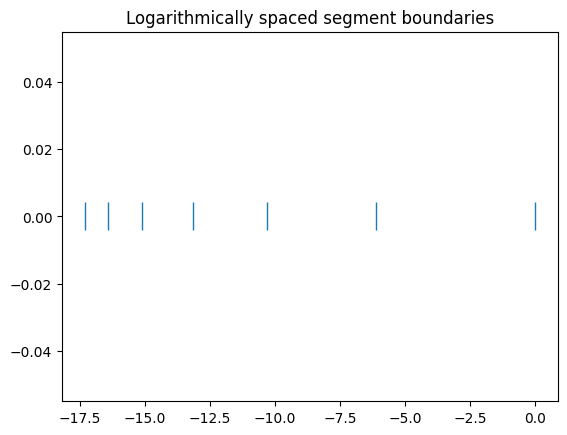

In [262]:
import matplotlib.pyplot as plt
# Cut space into logarithmic cuts for correct rounding
x = log_segments(np.nextafter(lower_bound, np.inf, dtype=np.float64), 0, 7)
print(x)
plt.plot(x, np.zeros_like(x), '|', markersize=20)
plt.title("Logarithmically spaced segment boundaries")
plt.show()

In [250]:
import numpy as np
import cvxpy as cp

def GenPoly(intervals, d):
    X = np.array([iv[0] for iv in intervals])
    L = np.array([iv[1][0] for iv in intervals])
    H = np.array([iv[1][1] for iv in intervals])


    # print(X, L, H)

    # Assertions for inputs
    n = len(X)
    assert len(L) == n and len(H) == n, "X, L, and H must be same length"
    assert d >= 0, "Degree must be non-negative"

    # Polynomial coefficients: a_0 + a_1 x + a_2 x^2 + ... + a_d x^d
    coeffs = cp.Variable(d + 1)

    # Build design matrix for P(x_i)
    V = np.vander(X, d + 1, increasing=True)  # shape (n, d+1)

    # Polynomial values at points X
    P_vals = V @ coeffs

    # The Constraints l_i <= P(x_i) <= h_i
    constraints = [P_vals >= L, P_vals <= H]

    # Minimisation problem for convex graph
    objective = cp.Minimize(cp.norm(coeffs, 10))  # Optional: regularize coefficients

    # Solve using SCS (don't use clarabel)
    prob = cp.Problem(objective, constraints)
    prob.solve(solver = cp.SCS)

    if prob.status != "optimal":
        raise ValueError("No feasible polynomial found.")

    # Value error if npthing is found
    if prob.status != "optimal":
        raise ValueError("No feasible polynomial found.")

    # Return as numpy poly1d for evalutation
    return np.poly1d(coeffs.value[::-1])  # return as numpy poly1d for evaluation

In [128]:
# Create values linearly spaced between the cut (linpspace not as effective as logspace)
X = np.linspace(x[0], x[1], 8)

intervals = CalcRndIntervals(X)
# print(dtype(intervals[0][1][0]))
# print(f"{X[0] :25f}", f"{sigmoid_float(X[0]) :.25f}")

In [269]:
cut_l = 0
cut_h = 1

def PolynomialApproximation(cut_l, cut_h, n):

  # Break cut into logarithmic segements
  X = log_segments(x[cut_l], x[cut_h], n)
  intervals = CalcRndIntervals(X)

  d = 1
  P = None

  while d < 12:
      try:
          P = GenPoly(intervals, d=d)

          # Evaluate the polynomial at X and compare with expected dtype values
          float_X = np.array([dtype(P(i)) for i in X])
          sigmoid_float_X = np.array([sigmoid_float(i) for i in X])

          # Check if all approximations match exactly in floating point
          if np.all(float_X == sigmoid_float_X):
              print(f"Match found at degree {d}")
              break  # Exit the loop — we found a matching polynomial


      except ValueError:
          print(f"Degree {d} not working")
          d += 1

  return P

P = PolynomialApproximation(cut_l, cut_h, 200)
print(P)

Match found at degree 1
 
-3.078e-09 x + 2.981e-10


[5.36331875e-08 5.36276320e-08 5.36220764e-08 5.36165208e-08
 5.36109652e-08 5.36054096e-08 5.35998541e-08 5.35942985e-08
 5.35887429e-08 5.35831873e-08 5.35776318e-08 5.35720762e-08
 5.35665206e-08 5.35609650e-08 5.35554094e-08 5.35498539e-08
 5.35442983e-08 5.35387427e-08 5.35331871e-08 5.35276315e-08
 5.35220760e-08 5.35165204e-08 5.35109648e-08 5.35054092e-08
 5.34998536e-08 5.34942981e-08 5.34887425e-08 5.34831869e-08
 5.34776313e-08 5.34720758e-08 5.34665202e-08 5.34609646e-08
 5.34554090e-08 5.34498534e-08 5.34442979e-08 5.34387423e-08
 5.34331867e-08 5.34276311e-08 5.34220755e-08 5.34165200e-08
 5.34109644e-08 5.34054088e-08 5.33998532e-08 5.33942976e-08
 5.33887421e-08 5.33831865e-08 5.33776309e-08 5.33720753e-08
 5.33665197e-08 5.33609642e-08 5.33554086e-08 5.33498530e-08
 5.33442974e-08 5.33387419e-08 5.33331863e-08 5.33276307e-08
 5.33220751e-08 5.33165195e-08 5.33109640e-08 5.33054084e-08
 5.32998528e-08 5.32942972e-08 5.32887416e-08 5.32831861e-08
 5.32776305e-08 5.327207

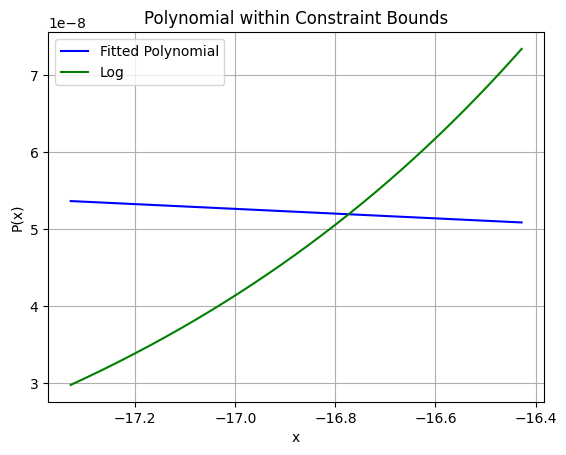

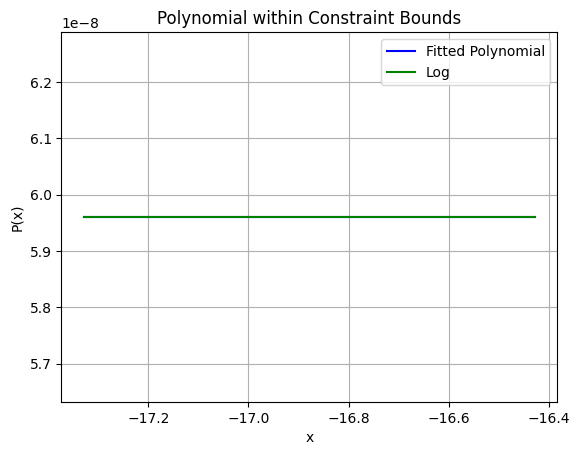

In [270]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a smooth range of x values for plotting
x_vals = np.linspace(x[cut_l], x[cut_h], 500)
y_vals = P(x_vals)
print(y_vals)
log_vals = [mp_sigmoid(x) for x in x_vals]
y_vals_rnd = dtype(y_vals)
print(y_vals_rnd)
log_vals_rnd = [sigmoid_float(x) for x in x_vals]
print(X)

# Plot the polynomial curve
plt.plot(x_vals, y_vals, label='Fitted Polynomial', color='blue')
plt.plot(x_vals, log_vals, label='Log', color='green')

# Axis and legend
plt.title('Polynomial within Constraint Bounds')
plt.xlabel('x')
plt.ylabel('P(x)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the polynomial curve
plt.plot(x_vals, y_vals_rnd, label='Fitted Polynomial', color='blue')
plt.plot(x_vals, log_vals_rnd, label='Log', color='green')
# plt.scatter(X, dtype(P(X)))

# Axis and legend
plt.title('Polynomial within Constraint Bounds')
plt.xlabel('x')
plt.ylabel('P(x)')
plt.legend()
plt.grid(True)
plt.show()
